In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import cv2 
import sys 
import glob
import random

%matplotlib inline
import matplotlib.pyplot as plt

import os
import math

sys.path.append('../utils')
sys.path.append('../models')
from dataloaders import *
from unet_blocks import *
from metrics_and_losses import *


import rasterio

In [38]:
USE_CUDA = torch.cuda.is_available()
DEVICE = 2
def w(v):
    if USE_CUDA:
        return v.cuda(DEVICE)
    return v

In [39]:
# model = torch.load('../weights/onera/3dconv_seg.pt')
model = w(UNetClassify(layers=6, init_filters=32, num_channels=13, fusion_method='mul'))
weights = torch.load('../../weights/onera/unet_siamese_prod_relu_inp64_13band_2dates_focal_hm_cnc_all_14_cities.pt')
model.load_state_dict(weights)
model.eval()

UNetClassify(
  (down_layers): ModuleList(
    (0): UNetDownBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): UNetDownBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
      (pool): MaxPool2d(kernel_size=2, stride=2, pa

In [2]:
dataset = full_onera_loader('../../datasets/onera/', ['B01','B02', 'B03', 'B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'])

In [40]:
cities = list(dataset.keys())
cities.sort()

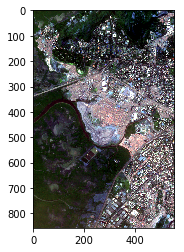

In [36]:
img = dataset['mumbai']['images']
img = np.rot90(img, random.randint(0,3), [2,3])
rgb = cv2.merge([img[1][0],img[2][0],img[3][0]])
plt.imshow(rgb)

/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


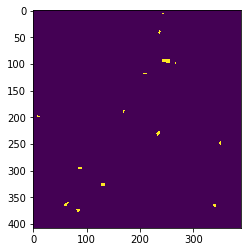

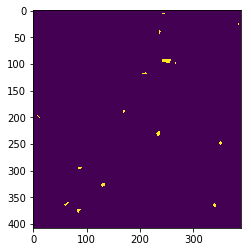

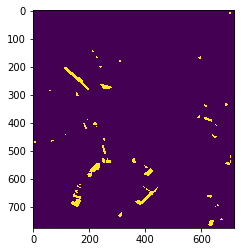

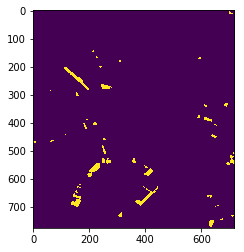

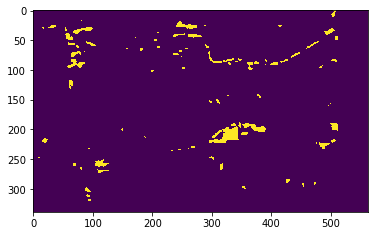

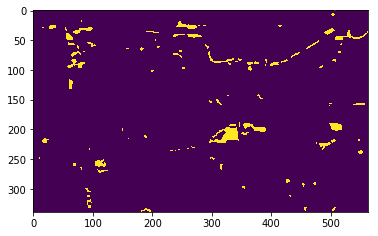

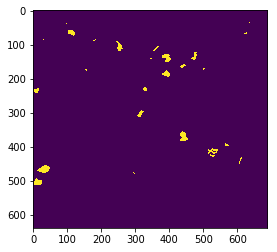

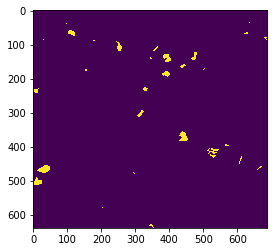

In [42]:
input_size = 64
for city in cities[10:]:
    img = dataset[city]['images']
    label = dataset[city]['labels']
    out = np.zeros((img.shape[2],img.shape[3]))
    
    for i in range(0,img.shape[2]//input_size):
        for j in range(0,img.shape[3]//input_size):
            if i*input_size + input_size < img.shape[2] and j*input_size + input_size < img.shape[3]:
                patch = np.transpose(img[:, : ,i*input_size:i*input_size+input_size, j*input_size:j*input_size+input_size], (1,0,2,3))
                inp1 = w(torch.from_numpy(np.asarray([patch[0]])))
                inp2 = w(torch.from_numpy(np.asarray([patch[1]])))
                logits = model(inp1, inp2)
#                 print (logits.min(),logits.max())
                pred = F.sigmoid(logits) > 0.5
                pred = pred.data.cpu().numpy()[0]
                out[i*input_size:i*input_size+input_size,j*input_size:j*input_size+input_size] = pred    
                
    rgb1 = cv2.merge([img[1][0], img[2][0], img[3][0]])
    rgb2 = cv2.merge([img[1][1], img[2][1], img[3][1]])
    
    

    plt.imshow(out)
    plt.show()
    plt.imshow(label)
    plt.show()
    

In [43]:
test_cities = ['brasilia', 'chongqing', 'dubai', 'lasvegas', 'milano', 'montpellier', 'norcia', 'rio', 'saclay_w', 'valencia']
input_size = 64
cities_out = {}

(433, 469) (433, 469)


/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


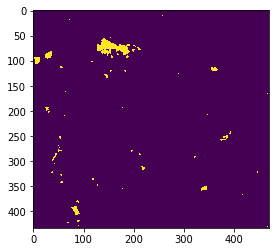

(730, 544) (730, 544)


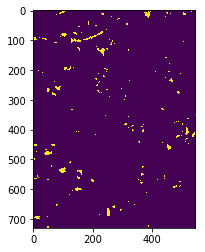

(774, 634) (774, 634)


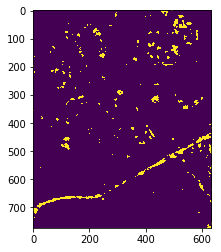

(824, 716) (824, 716)


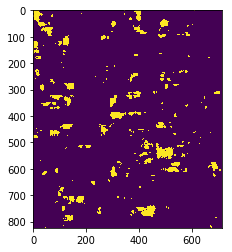

(545, 558) (545, 558)


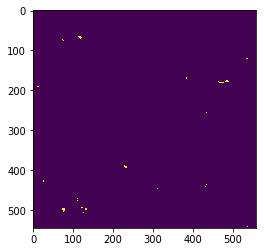

(426, 451) (426, 451)


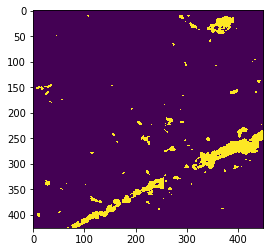

(241, 385) (241, 385)


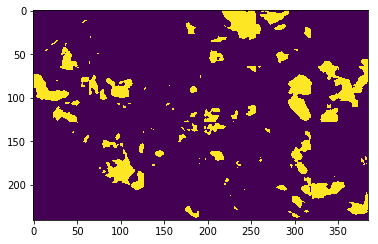

(353, 426) (353, 426)


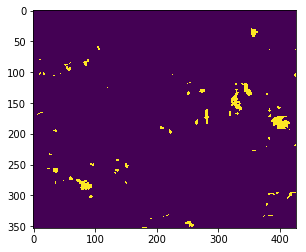

(639, 688) (631, 679)


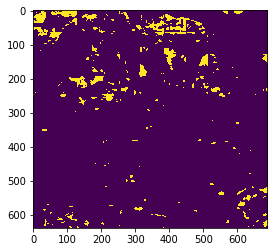

(458, 476) (458, 476)


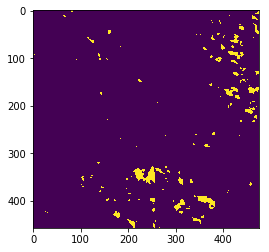

In [44]:
for city in test_cities:
    d1_bands = glob.glob('../../datasets/onera/images/'+ city +'/imgs_1/*.tif')
    d1_bands.sort()
    
    d1b1 = rasterio.open(d1_bands[0])
    d1b2 = rasterio.open(d1_bands[1])
    d1b3 = rasterio.open(d1_bands[2])
    d1b4 = rasterio.open(d1_bands[3])
    d1b5 = rasterio.open(d1_bands[4])
    d1b6 = rasterio.open(d1_bands[5])
    d1b7 = rasterio.open(d1_bands[6])
    d1b8 = rasterio.open(d1_bands[7])
    d1b8a = rasterio.open(d1_bands[8])
    d1b9 = rasterio.open(d1_bands[9])
    d1b10 = rasterio.open(d1_bands[10])
    d1b11 = rasterio.open(d1_bands[11])
    d1b12 = rasterio.open(d1_bands[12])
    
    d2_bands = glob.glob('../../datasets/onera/images/'+ city +'/imgs_2/*.tif')
    d2_bands.sort()
    
    d2b1 = rasterio.open(d2_bands[0])
    d2b2 = rasterio.open(d2_bands[1])
    d2b3 = rasterio.open(d2_bands[2])
    d2b4 = rasterio.open(d2_bands[3])
    d2b5 = rasterio.open(d2_bands[4])
    d2b6 = rasterio.open(d2_bands[5])
    d2b7 = rasterio.open(d2_bands[6])
    d2b8 = rasterio.open(d2_bands[7])
    d2b8a = rasterio.open(d2_bands[8])
    d2b9 = rasterio.open(d2_bands[9])
    d2b10 = rasterio.open(d2_bands[10])
    d2b11 = rasterio.open(d2_bands[11])
    d2b12 = rasterio.open(d2_bands[12])
    
    print (d1b2.shape, d2b2.shape)
    
    d1_b2 = d1b2.read()[0]
    d1_b1 = cv2.resize(d1b1.read()[0], (d1_b2.shape[1], d1_b2.shape[0]))
    d1_b3 = cv2.resize(d1b3.read()[0], (d1_b2.shape[1], d1_b2.shape[0]))
    d1_b4 = cv2.resize(d1b4.read()[0], (d1_b2.shape[1], d1_b2.shape[0]))
    d1_b5 = cv2.resize(d1b5.read()[0], (d1_b2.shape[1], d1_b2.shape[0]))
    d1_b6 = cv2.resize(d1b6.read()[0], (d1_b2.shape[1], d1_b2.shape[0]))
    d1_b7 = cv2.resize(d1b7.read()[0], (d1_b2.shape[1], d1_b2.shape[0]))
    d1_b8 = cv2.resize(d1b8.read()[0], (d1_b2.shape[1], d1_b2.shape[0]))
    d1_b8a = cv2.resize(d1b8a.read()[0], (d1_b2.shape[1], d1_b2.shape[0]))
    d1_b9 = cv2.resize(d1b9.read()[0], (d1_b2.shape[1], d1_b2.shape[0]))
    d1_b10 = cv2.resize(d1b10.read()[0], (d1_b2.shape[1], d1_b2.shape[0]))
    d1_b11 = cv2.resize(d1b11.read()[0], (d1_b2.shape[1], d1_b2.shape[0]))
    d1_b12 = cv2.resize(d1b12.read()[0], (d1_b2.shape[1], d1_b2.shape[0]))
    
    d2_b2 = cv2.resize(d2b2.read()[0], (d1_b2.shape[1], d1_b2.shape[0]))
    d2_b1 = cv2.resize(d2b1.read()[0], (d1_b2.shape[1], d1_b2.shape[0]))
    d2_b3 = cv2.resize(d2b3.read()[0], (d1_b2.shape[1], d1_b2.shape[0]))
    d2_b4 = cv2.resize(d2b4.read()[0], (d1_b2.shape[1], d1_b2.shape[0]))
    d2_b5 = cv2.resize(d2b5.read()[0], (d1_b2.shape[1], d1_b2.shape[0]))
    d2_b6 = cv2.resize(d2b6.read()[0], (d1_b2.shape[1], d1_b2.shape[0]))
    d2_b7 = cv2.resize(d2b7.read()[0], (d1_b2.shape[1], d1_b2.shape[0]))
    d2_b8 = cv2.resize(d2b8.read()[0], (d1_b2.shape[1], d1_b2.shape[0]))
    d2_b8a = cv2.resize(d2b8a.read()[0], (d1_b2.shape[1], d1_b2.shape[0]))
    d2_b9 = cv2.resize(d2b9.read()[0], (d1_b2.shape[1], d1_b2.shape[0]))
    d2_b10 = cv2.resize(d2b10.read()[0], (d1_b2.shape[1], d1_b2.shape[0]))
    d2_b11 = cv2.resize(d2b11.read()[0], (d1_b2.shape[1], d1_b2.shape[0]))
    d2_b12 = cv2.resize(d2b12.read()[0], (d1_b2.shape[1], d1_b2.shape[0]))
    
    d2_b1 = match_band(d2_b1, d1_b1)
    d2_b2 = match_band(d2_b2, d1_b2)
    d2_b3 = match_band(d2_b3, d1_b3)
    d2_b4 = match_band(d2_b4, d1_b4)
    d2_b5 = match_band(d2_b5, d1_b5)
    d2_b6 = match_band(d2_b6, d1_b6)
    d2_b7 = match_band(d2_b7, d1_b7)
    d2_b8 = match_band(d2_b8, d1_b8)
    d2_b8a = match_band(d2_b8a, d1_b8a)
    d2_b9 = match_band(d2_b9, d1_b9)
    d2_b10 = match_band(d2_b10, d1_b10)
    d2_b11 = match_band(d2_b11, d1_b11)
    d2_b12 = match_band(d2_b12, d1_b12)
    
         
    d1_b1 = stretch_8bit(d1_b1, 2, 98).astype(np.float32)
    d1_b2 = stretch_8bit(d1_b2, 2, 98).astype(np.float32)
    d1_b3 = stretch_8bit(d1_b3, 2, 98).astype(np.float32)
    d1_b4 = stretch_8bit(d1_b4, 2, 98).astype(np.float32)
    d1_b5 = stretch_8bit(d1_b5, 2, 98).astype(np.float32)
    d1_b6 = stretch_8bit(d1_b6, 2, 98).astype(np.float32)
    d1_b7 = stretch_8bit(d1_b7, 2, 98).astype(np.float32)
    d1_b8 = stretch_8bit(d1_b8, 2, 98).astype(np.float32)
    d1_b8a = stretch_8bit(d1_b8a, 2, 98).astype(np.float32)
    d1_b9 = stretch_8bit(d1_b9, 2, 98).astype(np.float32)
    d1_b10 = stretch_8bit(d1_b10, 2, 98).astype(np.float32)
    d1_b11 = stretch_8bit(d1_b11, 2, 98).astype(np.float32)
    d1_b12 = stretch_8bit(d1_b12, 2, 98).astype(np.float32)

    d2_b1 = stretch_8bit(d2_b1, 2, 98).astype(np.float32)
    d2_b2 = stretch_8bit(d2_b2, 2, 98).astype(np.float32)
    d2_b3 = stretch_8bit(d2_b3, 2, 98).astype(np.float32)
    d2_b4 = stretch_8bit(d2_b4, 2, 98).astype(np.float32)
    d2_b5 = stretch_8bit(d2_b5, 2, 98).astype(np.float32)
    d2_b6 = stretch_8bit(d2_b6, 2, 98).astype(np.float32)
    d2_b7 = stretch_8bit(d2_b7, 2, 98).astype(np.float32)
    d2_b8 = stretch_8bit(d2_b8, 2, 98).astype(np.float32)
    d2_b8a = stretch_8bit(d2_b8a, 2, 98).astype(np.float32)
    d2_b9 = stretch_8bit(d2_b9, 2, 98).astype(np.float32)
    d2_b10 = stretch_8bit(d2_b10, 2, 98).astype(np.float32)
    d2_b11 = stretch_8bit(d2_b11, 2, 98).astype(np.float32)
    d2_b12 = stretch_8bit(d2_b12, 2, 98).astype(np.float32)
    
    img1 = np.asarray([d1_b1, d1_b2, d1_b3, d1_b4, d1_b5, d1_b6, d1_b7, d1_b8, d1_b8a, d1_b9, d1_b10, d1_b11, d1_b12]).astype(np.float32) / 255.
    img2 = np.asarray([d2_b1, d2_b2, d2_b3, d2_b4, d2_b5, d2_b6, d2_b7, d2_b8, d2_b8a, d2_b9, d2_b10, d2_b11, d2_b12]).astype(np.float32) / 255.

    out = np.zeros((img1.shape[1],img1.shape[2]))
    
    batches1 = []
    batches2 = []
    ijs = []
    for i in range(0,img1.shape[1],64):
        for j in range(0,img1.shape[2],64):
            if i+input_size <= img1.shape[1] and j+input_size <= img1.shape[2]:
                batches1.append(img1[:,i:i+input_size,j:j+input_size])
                batches2.append(img2[:,i:i+input_size,j:j+input_size])
                ijs.append([i,j])
            elif i+input_size>img1.shape[1] and j+input_size<=img1.shape[2]:
                batches1.append(img1[:,img1.shape[1]-input_size:img1.shape[1],j:j+input_size])
                batches2.append(img2[:,img2.shape[1]-input_size:img2.shape[1],j:j+input_size])
                ijs.append([img1.shape[1]-input_size,j])
            elif i+input_size<=img1.shape[1] and j+input_size>img1.shape[2]:
                batches1.append(img1[:,i:i+input_size,img1.shape[2]-input_size:img1.shape[2]])
                batches2.append(img2[:,i:i+input_size,img2.shape[2]-input_size:img2.shape[2]])
                ijs.append([i,img1.shape[2]-input_size])
            else:
                batches1.append(img1[:,img1.shape[1]-input_size:img1.shape[1],
                                     img1.shape[2]-input_size:img1.shape[2]])
                batches2.append(img2[:,img2.shape[1]-input_size:img2.shape[1],
                                     img2.shape[2]-input_size:img2.shape[2]])
                ijs.append([img1.shape[1]-input_size,img1.shape[2]-input_size])
                
            if len(batches1) == 1:
                inp1 = w(torch.from_numpy(np.asarray(batches1)))
                inp2 = w(torch.from_numpy(np.asarray(batches2)))
#                 print (inp1.size(),inp2.size())
                logits = model(inp1, inp2)
                pred = F.sigmoid(logits) > 0.5
                pred = pred.data.cpu().numpy()
                
                batches1 = []
                batches2 = []
                
                del inp1
                del inp2
                
                for c in range(len(ijs)):
                    out[ijs[c][0]:ijs[c][0]+input_size,ijs[c][1]:ijs[c][1]+input_size] = pred[c]
                    
                ijs = []
    
    cities_out[city] = out
    plt.imshow(out)
    plt.show()
    

In [9]:
for city in list(cities_out.keys()):
    new_dataset = rasterio.open('../../datasets/onera/results/' + city + '_focal_14dates_s64_13bands_inp64.tif', 'w', driver='GTiff', 
                                height=cities_out[city].shape[0], width=cities_out[city].shape[1], count=1, dtype=np.uint8)
    new_dataset.write(cities_out[city].astype(np.uint8) + 1, 1)
    new_dataset.close()

/usr/local/lib/python3.5/dist-packages/rasterio/__init__.py:253: NotGeoreferencedWarning: Dataset has no geotransform set. Default transform will be applied (Affine.identity())
  **kwargs)


In [49]:
def frange(x, y, jump):
    while x < y:
        yield x
        x += jump

In [64]:
outx = []
inx = []
for i in frange(0.01,1.0,0.01):
    outx.append(-(1-i)**0.023 * math.log(i))
    inx.append(i)

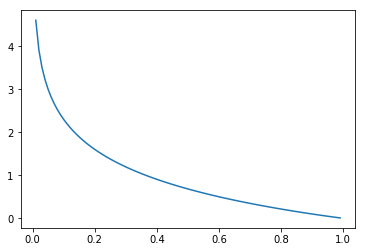

In [65]:
plt.plot(inx,outx)